In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Import Data

The CSV of measurements was collected by the script "Diagtools/arduino_serial_rw_plot.py"  It contains a time series of LED states for our oscillating stimulus and voltage measurements for two light measurement sensors.

In [48]:
# s02_230218_white_randFreq_SegmentMode.csv
data = pd.read_csv('../Measurements/s02_230218_white_randFreq_ObjectMode.csv')

In [53]:
data['Time'].max()/1000000

31.222524

## View Time Series

c:\users\mohammad bashiri\anaconda3\envs\detector\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


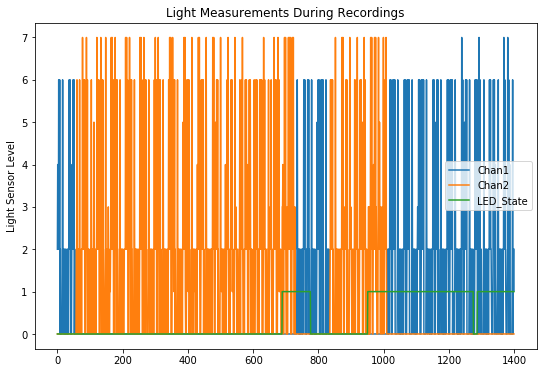

In [54]:
(data
  .iloc[:1400].plot(y=['Chan1', 'Chan2', 'LED_State'], figsize=(9, 6))
  .set(ylabel='Light Sensor Level',
       title='Light Measurements During Recordings')
);

### View Sampling Step size variance

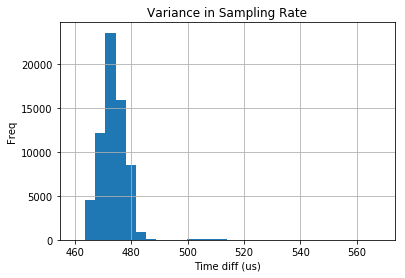

In [55]:
data.Time.diff().hist(bins=30)
plt.gca().set(xlabel='Time diff (us)', ylabel='Freq', title='Variance in Sampling Rate')
plt.show()

### Smoothing

c:\users\mohammad bashiri\anaconda3\envs\detector\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


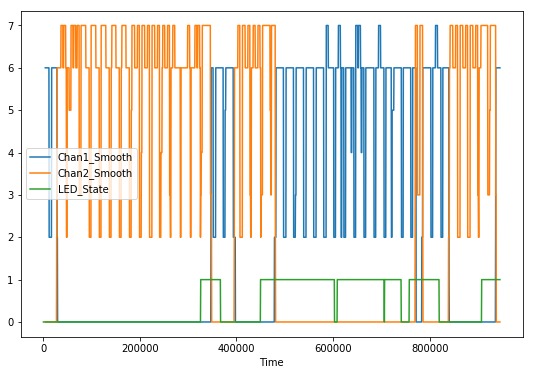

In [56]:
win_size = 9
data[['Chan1_Smooth', 'Chan2_Smooth']] = data[['Chan1', 'Chan2']].rolling(win_size).max()
data.iloc[:2000].plot('Time', ['Chan1_Smooth', 'Chan2_Smooth', 'LED_State'], figsize=(9, 6))
plt.show()

## Frame Detection

c:\users\mohammad bashiri\anaconda3\envs\detector\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


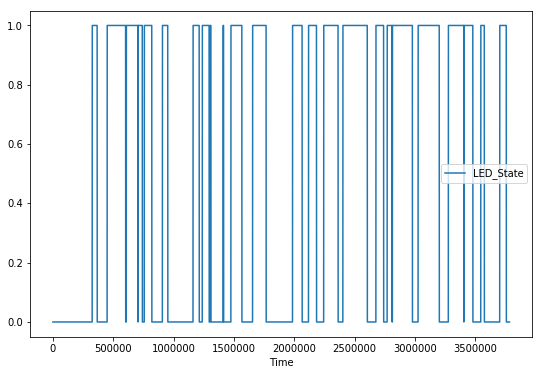

In [32]:
threshold = 5
data[['Frame1On', 'Frame2On']] = data[['Chan1_Smooth', 'Chan2_Smooth']] > threshold
data.iloc[:8000].plot('Time', ['Frame1On', 'Frame2On', 'LED_State'], figsize=(9, 6))
plt.show()

## Trial Time

For latency measurements, we'll need time since the LED switched.

In [28]:
data['TrialTime'] = data.groupby('Trial').Time.apply(lambda x: x - x.min())
data.head()

,Time,Chan1,Chan2,Trial,LED_State,Chan1_Smooth,Chan2_Smooth,Frame1On,Frame2On,TrialTime
0,192,6,0,0,0,NaN,NaN,False,False,0
1,760,0,0,0,0,NaN,NaN,False,False,568
2,1240,0,0,0,0,NaN,NaN,False,False,1048
3,1704,0,0,0,0,NaN,NaN,False,False,1512
4,2184,0,0,0,0,NaN,NaN,False,False,1992


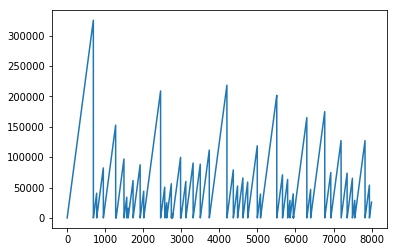

In [29]:
data.TrialTime.iloc[:8000].plot()
plt.show()

## Onset Detection for Each Trial

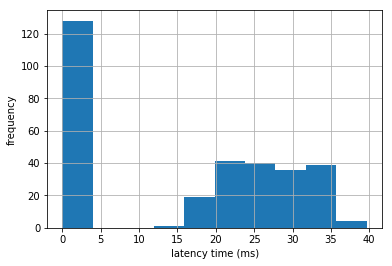

In [30]:
# data[(data[['Frame1On', 'Frame2On']].astype(int).diff() == 1).any(axis=1)]
resp_on = data[(data['Frame1On'] & (data['LED_State'] == 1)) | (data['Frame2On'] & (data['LED_State'] == 0))]
latency = resp_on.groupby('Trial').TrialTime.min()
(latency / 1000).hist().set(xlabel='latency time (ms)', ylabel='frequency')
plt.show()

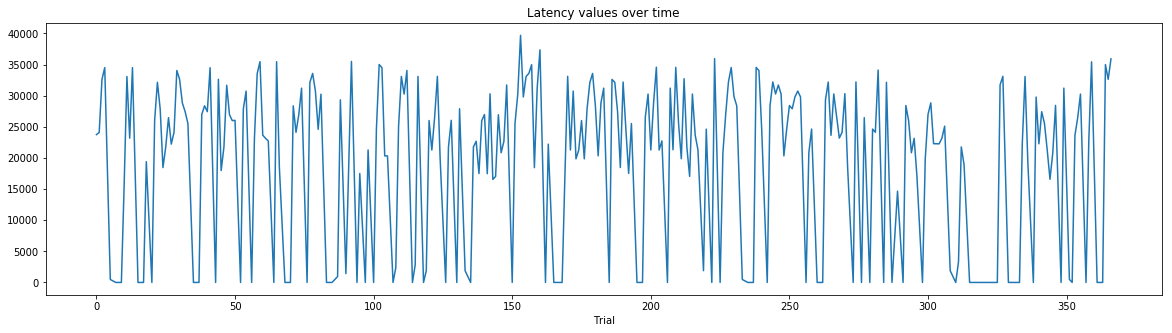

In [20]:
latency.plot(figsize=(20,5)).set(title='Latency values over time')
plt.show()

## For separate channels (grouping based on Trial and LED_State)

In [ ]:
grouped = data.groupby(['LED_State', 'Trial'])

In [ ]:
levels = grouped.size().index.levels[0]

In [ ]:
latency = np.zeros((len(levels), sum(grouped.size().index.labels[0] == 1)))
for key in grouped.indices.keys():
    if key[0]:
        latency[key[0], key[1]//len(levels)] = grouped.get_group(key).index[0] - grouped.get_group(key).index[grouped.get_group(key).Chan1 != 0][0]
    else:
        latency[key[0], key[1]//len(levels)] = grouped.get_group(key).index[0] - grouped.get_group(key).index[grouped.get_group(key).Chan2 != 0][0]

In [ ]:
latency = np.abs(latency)

In [ ]:
plotIt(
    pd.DataFrame(latency[0,:]), 
    title='Chan1',
    xlabel='latency time (us)',
    plot_hist=True)

In [ ]:
plotIt(
    pd.DataFrame(latency[0,:]), 
    xlabel='Time (us)', 
    title='Latency values over time (Chan1)', 
    figsize=(20,5)
)

In [ ]:
plotIt(
    pd.DataFrame(latency[1,:]), 
    title='Chan2',
    xlabel='latency time (us)',
    plot_hist=True)

In [ ]:
plotIt(
    pd.DataFrame(latency[1,:]), 
    xlabel='Time (us)', 
    title='Latency values over time (Chan2)', 
    figsize=(20,5)
)

# How does smoothing infleunces this value?

- Sampling frequency = fs
- Rolling value = 9, centered=True

Then, the value present at any point in the smoothened signal, might be shifter 10/2 samples forward. To be safe, we are gonna consider the worst case scenario, that is:

floor(9/2) * 1/fs

In [ ]:
# finding the worst case sampling frequency
timing_data = data.index.values
timing_data_diff = np.diff(timing_data)
fs = 1/(np.max(timing_data_diff)*10**-6)
fs

In [ ]:
9//2 * 1/fs

So in this case there is could be maximum error of around 2 ms